In [1]:
import pykalman

import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

In [2]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0
print(data_dir_full)
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913
load *SessionPulses.Events.mat failed


In [3]:
from pykalman import KalmanFilter

In [34]:
prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)

/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/spk_beh_df.p saved!


In [15]:
beh_df = spk_beh_df[['lin','v','x','y']]#.dropna(axis=0)
lin = beh_df['lin']
xy =beh_df[['x','y']]
v = beh_df['v']


In [5]:
dt = np.median(np.diff(spk_beh_df.query("task_index==0").index))

In [5]:
reload(dpp)

<module 'data_prep_pyn' from '/mnt/home/szheng/projects/util_code/data_prep_pyn.py'>

In [16]:
%%time
xy_smth = dpp.get_speed_kalman(xy,dt,order=2)

CPU times: user 15.5 s, sys: 35.4 ms, total: 15.6 s
Wall time: 15.6 s


In [17]:
v

Time (s)
7865.562433    NaN
7865.595767    NaN
7865.629100    NaN
7865.662433    NaN
7865.695800    NaN
                ..
10017.539300   NaN
10017.572633   NaN
10017.605967   NaN
10017.639333   NaN
10017.672667   NaN
Name: v, Length: 64576, dtype: float64

In [27]:
reload(dpp)
beh_df = dpp.get_multi_maze_behavior_df(behavior)

/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


<AxesSubplot:xlabel='Time (s)'>

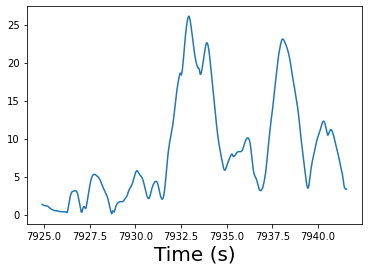

In [32]:
beh_df['speed_kalman'].iloc[2000:2500].plot()

<AxesSubplot:xlabel='Time (s)'>

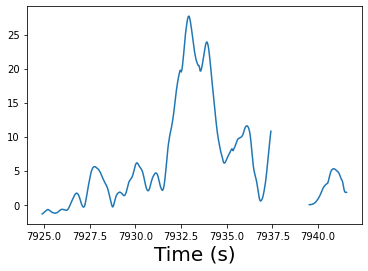

In [33]:
beh_df['v'].iloc[2000:2500].plot()

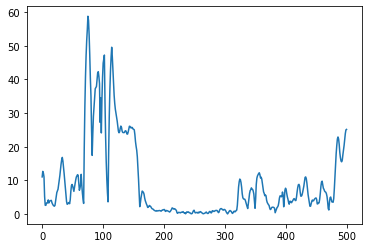

In [22]:
%matplotlib inline
sp = dpn.smooth_get_speed(xy_smth[:,0:2],dt,sigma=0.0001,is2d=True)[0]
plt.plot(sp[1500:2000])

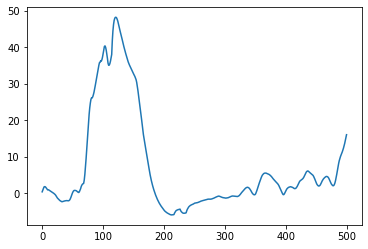

In [23]:
plt.plot(v.values[1500:2000])

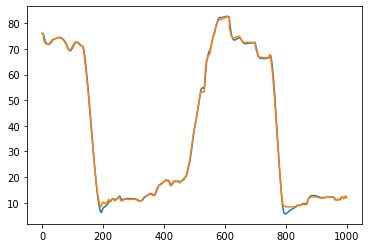

In [14]:
%matplotlib inline
plt.plot(xy_smth[:,0])
plt.plot(xy['x'].values)

In [148]:
# xy = copy.copy(beh_df[['lin']])
# xy['y']=0
# xy.values

array([[  4.60825811,   0.        ],
       [  4.60825811,   0.        ],
       [  4.60825811,   0.        ],
       ...,
       [114.8550031 ,   0.        ],
       [114.59710891,   0.        ],
       [114.16728525,   0.        ]])

In [193]:
%%time
order =2
dt =np.median(np.diff(spk_beh_df.query("task_index==0").index)) 

R = np.eye(2) 

if order==1:
    transition_matrix = np.array([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])
    Q = 0.1 * np.eye(transition_matrix.shape[0])    
    ob_mat = np.array([[1,0,0,0],[0,1,0,0]])
    initial_state_mean = np.concatenate([xy.values[0,:],[0,0]])
elif order==2:
    transition_matrix = np.array([[1,0,dt,0,1/2*dt**2,0],[0,1,0,dt,0,1/2*dt**2],[0,0,1,0,dt,0],[0,0,0,1,0,dt],[0,0,0,0,1,0],[0,0,0,0,0,1]])
    Q = 0.1 * np.eye(transition_matrix.shape[0])    
    ob_mat = np.array([[1,0,0,0,0,0],[0,1,0,0,0,0]])
    initial_state_mean = np.concatenate([xy.values[0,:],[0,0,0,0]])
    
kf = KalmanFilter(transition_matrices=transition_matrix,initial_state_mean=initial_state_mean,
                  observation_matrices=ob_mat,transition_covariance=Q,observation_covariance=R,
                  n_dim_obs=2)
# kf = kf.em(xy.values,n_iter=2,em_vars=['transition_covariance', 'observation_covariance'])
# xy_smth,_ = kf.smooth(xy.values)
xy_smth,_ = kf.filter(xy.values)


CPU times: user 297 ms, sys: 52.2 ms, total: 349 ms
Wall time: 348 ms


In [194]:
if order==1:
    xy_smth_df = pd.DataFrame(xy_smth,columns=['x_smth','y_smth','vx_smth','vy_smth'])
elif order==2:
    xy_smth_df = pd.DataFrame(xy_smth,columns=['x_smth','y_smth','vx_smth','vy_smth','ax_smth','ay_smth'])
xy_smth_df.index=beh_df.index
beh_df_smth = pd.concat([beh_df,xy_smth_df],axis=1)
beh_df_smth['speed_smth'] = np.sqrt(beh_df_smth['vx_smth']**2+beh_df_smth['vy_smth']**2)
beh_df_smth['v_abs'] = beh_df_smth['v'].abs()

<AxesSubplot:xlabel='Time (s)'>

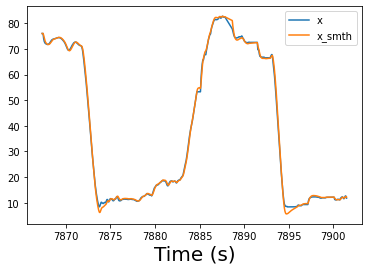

In [195]:
beh_df_smth[['x','x_smth']].plot()
# beh_df_smth[['lin','x_smth']].plot()

In [196]:
kf.transition_covariance.round(1)

array([[0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.1, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.1]])

<AxesSubplot:xlabel='Time (s)'>

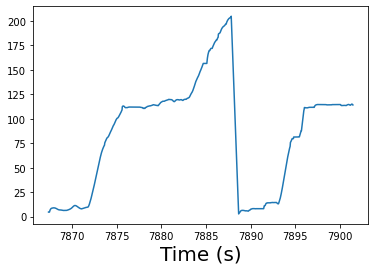

In [199]:
beh_df_smth['lin'].plot()

<AxesSubplot:xlabel='Time (s)'>

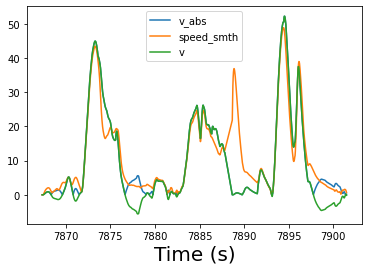

In [197]:
beh_df_smth[['v_abs','speed_smth','v']].iloc[:1000].plot()

In [50]:
(filtered_state_means, filtered_state_covariances) = kf.filter(xy.values[:100])

In [53]:
filtered_state_means

array([[ 8.61487568e+01,  4.39093403e+01,  0.00000000e+00,
         0.00000000e+00],
       [ 8.61487568e+01,  4.39093403e+01,  1.14891638e-10,
         1.89397679e-11],
       [ 8.61487569e+01,  4.39093403e+01,  2.15365068e-09,
         3.55026497e-10],
       [ 8.61487570e+01,  4.39093404e+01,  1.60063321e-08,
         2.63862178e-09],
       [ 8.60982320e+01,  4.40569370e+01, -5.68091200e-03,
         1.65954453e-02],
       [ 8.60087261e+01,  4.43027677e+01, -1.85929021e-02,
         5.20538310e-02],
       [ 8.59040737e+01,  4.46342232e+01, -3.69576019e-02,
         1.10258810e-01],
       [ 8.57988317e+01,  4.50185058e+01, -5.86048284e-02,
         1.89473168e-01],
       [ 8.55746287e+01,  4.56635186e+01, -1.11776864e-01,
         3.42278084e-01],
       [ 8.48525322e+01,  4.59625212e+01, -3.05598989e-01,
         4.19873085e-01],
       [ 8.41349983e+01,  4.61457849e+01, -5.17631517e-01,
         4.70612393e-01],
       [ 8.35664109e+01,  4.63362734e+01, -6.99044332e-01,
      

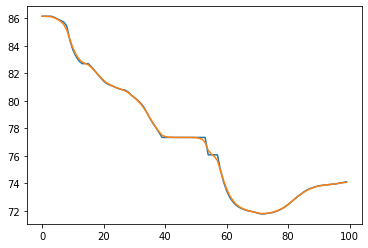

In [70]:
%matplotlib inline
plt.plot(xy.values[:100,0])
plt.plot(xy_smth[0][:100,0])


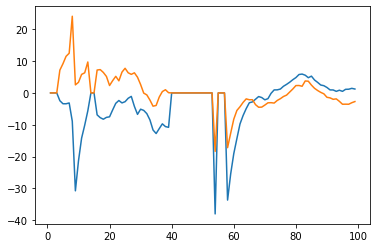

In [73]:
plt.plot((xy.diff() / dt).values[:100,0])
plt.plot((xy.diff() / dt).values[:100,1])

In [ ]:
plt.plot(lin.values[:100])

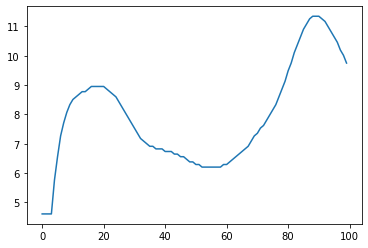

In [66]:
plt.plot(lin.values[:100])

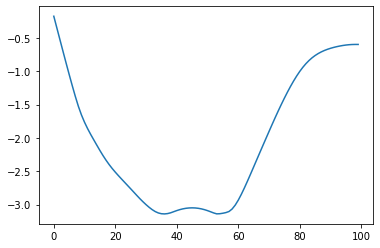

In [72]:

plt.plot(xy_smth[0][:100,2])